In [30]:
import numpy as np
import pandas as pd
import xgboost as xgb
import catboost as cb
import matplotlib.pyplot as plt

In [31]:
def boosted_model(model_no):
	model_name = 'Xgboost'
	model = xgb.XGBRegressor(objective = 'reg:absoluteerror', booster='gbtree', steps=20, learning_rate=0.1, max_depth=5) 
	if model_no: # 0=Xgboost, 1=Catboost
		model_name = 'Catboost'
		model = cb.CatBoostRegressor(objective = 'MAE', iterations=20, learning_rate=0.1, max_depth=5, verbose=0)  
	return model

In [32]:
boosted_model(0)

XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, objective='reg:absoluteerror', ...)

In [33]:
# Extract data
route = 20
station = 19
data = pd.read_csv("Data/Cleaned_data.csv")
y = data[(data['visualiseringskode'] == route) & (data['station'] == station)]['togpunktlighed'].values
X = data[(data['visualiseringskode'] == route) & (data['station'] == station)].iloc[:,2:]


# XGBoost with Simple Idea

In [34]:
# ACROSS different time slots. WHAT ABOUT ACROSS DIFFERENT route/station pairs but always the most recent time slot - unrealistic setting does not tell us much. 
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split

# Number of models to train in the ensemble
num_models = 10

# Test/train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=30, shuffle=False)

# Splitting the data into continuous chunks for training
chunk_size = len(X_train) // num_models  # Assuming equal-sized chunks
train_chunks_X = [X_train[i:i+chunk_size] for i in range(0, len(X_train), chunk_size)]
train_chunks_y = [y_train[i:i+chunk_size] for i in range(0, len(y_train), chunk_size)]

# Train ensemble of XGBoost models
models = []
for i in range(num_models):
    boosted_model = xgb.XGBRegressor(objective = 'reg:absoluteerror', booster='gbtree', steps=20, learning_rate=0.1, max_depth=5) 
    model = boosted_model.fit(train_chunks_X[i], train_chunks_y[i])
    models.append(model)

# Function to make predictions and estimate uncertainty
def predict_with_uncertainty(models, X_test):
    predictions = np.zeros((X_test.shape[0], len(models)))
    for i, model in enumerate(models):
        predictions[:, i] = model.predict(X_test)
    mean_prediction = np.mean(predictions, axis=1)
    uncertainty = np.std(predictions, axis=1)
    return mean_prediction, uncertainty

# Example usage
mean_pred, uncertainty = predict_with_uncertainty(models, X_test)
print("Mean Predictions:", mean_pred)
print("Uncertainty Estimates:", uncertainty)


/Users/clarasofiechristiansen/anaconda3/envs/DSB_Bachelorprojekt/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [12:01:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "steps" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/clarasofiechristiansen/anaconda3/envs/DSB_Bachelorprojekt/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [12:01:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "steps" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/clarasofiechristiansen/anaconda3/envs/DSB_Bachelorprojekt/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [12:01:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "steps" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/clarasofiechristiansen/anaconda3/envs/DSB_Bachelorprojekt/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [12:01:45] WARNING: /Users/runner/work

Mean Predictions: [0.78800874 0.86321303 0.86692839 0.83564258 0.82155189 0.79964926
 0.75750579 0.71056368 0.878574   0.87985192 0.81362416 0.77743399
 0.81285757 0.79479394 0.81140463 0.8641637  0.87124973 0.80622042
 0.81994921 0.81506035 0.80866545 0.84553658 0.86606776 0.87987108
 0.87313122 0.82256118 0.85528483 0.85869615 0.85774692 0.87330461]
Uncertainty Estimates: [0.05339406 0.02890126 0.03496154 0.0434951  0.04321803 0.05391671
 0.05549691 0.07725299 0.02270478 0.01987097 0.04898058 0.04273711
 0.03838789 0.03529246 0.05067694 0.02669465 0.02301546 0.04377937
 0.04036861 0.03929771 0.04348816 0.03703032 0.03412032 0.02248814
 0.0258294  0.03461146 0.03535825 0.03824491 0.04172818 0.03165444]


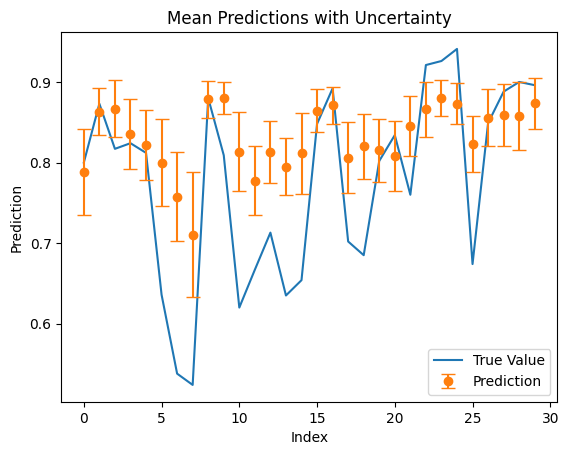

In [37]:
# Plot mean predictions with uncertainty
plt.plot(range(len(mean_pred)), y_test, label='True Value')
plt.errorbar(range(len(mean_pred)), mean_pred, yerr=uncertainty, fmt='o', capsize=5, label='Prediction')
plt.xlabel('Index')
plt.ylabel('Prediction')
plt.title('Mean Predictions with Uncertainty')
plt.legend()
plt.show()

# Catboost with Paper's Idea

In [85]:
def ensemble(train_pool, val_pool, test_pool, num_samples=10, iters=1000, lr=0.2):
    ens_preds = []
    for seed in range(num_samples):
        model = cb.CatBoostRegressor(iterations=iters, learning_rate=lr, 
                                  loss_function='RMSEWithUncertainty', posterior_sampling=True,
                                  verbose=False, random_seed=seed)
        model.fit(train_pool, eval_set=val_pool)
        ens_preds.append(model.predict(test_pool))
    return np.asarray(ens_preds)

In [95]:
# Split data into train, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=256, random_state=42, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, shuffle=True)

# Convert data into a format suitable for CatBoost
train_pool = cb.Pool(data=X_train, label=y_train)
val_pool = cb.Pool(data=X_val, label=y_val)
test_pool = cb.Pool(data=X_test, label=y_test)  # Provide labels for test data

In [96]:
ens_preds = ensemble(train_pool, val_pool, test_pool)

In [97]:
# Shape (models, test_size, estimates)
ens_preds.shape

(10, 256, 2)

In [98]:
# Prediction with uncertainty
ens_preds[0,0]

array([0.72957038, 0.00384718])

In [99]:
import seaborn as sns
data = np.mean(ens_preds, axis=0)[:, 1] # average estimated data uncertainty
knowledge = np.var(ens_preds, axis=0)[:, 0] # estimated knowledge uncertainty

Average predicted data uncertainty:


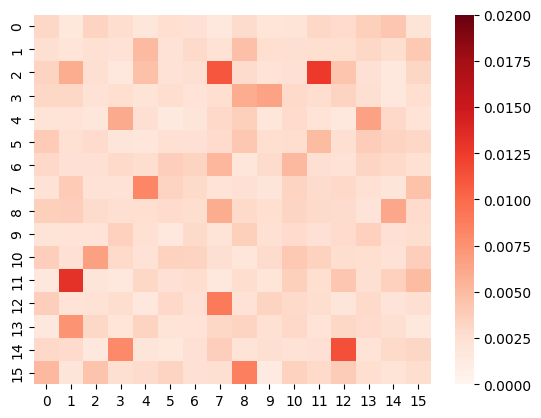

In [103]:
print("Average predicted data uncertainty:")            
sns.heatmap(data.reshape([16, 16]), cmap="Reds", vmin=0, vmax=0.02)
plt.savefig("heart_data_sglb.pdf")
plt.show()

Knowledge uncertainty via ensemble:


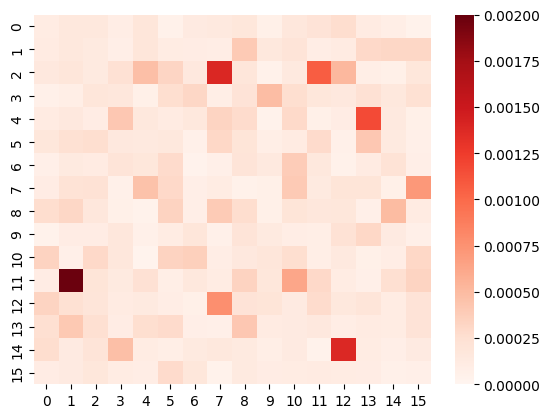

In [105]:
print("Knowledge uncertainty via ensemble:")            
sns.heatmap(knowledge.reshape([16, 16]), cmap="Reds", vmin=0, vmax=0.002)
plt.savefig("heart_knowledge_sglb.pdf")
plt.show()

For regression, data uncertainty is the average variance predicted by the models, while knowledge uncertainty can be obtained by measuring the variance of the mean across multiple models.

Data uncertainty arises due to the inherent complexity of the data, such as additive noise or overlapping classes. In these cases, the model knows that the input has attributes of multiple classes or that the target is noisy. Importantly, data uncertainty cannot be reduced by collecting more training data.

Knowledge uncertainty coming from the lack of training data in a particular region. If all the models understand an input, they will give similar predictions (low knowledge uncertainty). However, if the models do not understand the input, then they are likely to provide diverse predictions and strongly disagree with each other (high knowledge uncertainty). For regression, knowledge uncertainty can be obtained by measuring the variance of the mean across multiple models.


In [ ]:
#sorted_indices = np.argsort(y_test)
#sorted_y_test = y_test[sorted_indices]
#sorted_data_knowledge = (data + knowledge)[sorted_indices]

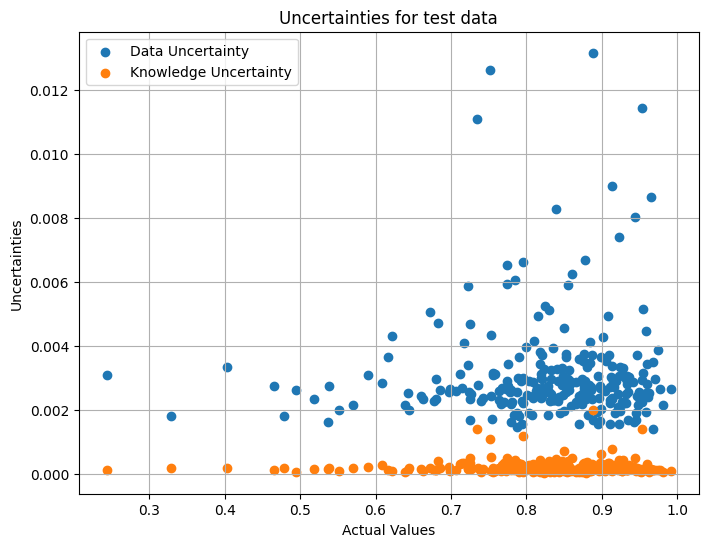

In [123]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, data, label='Data Uncertainty')
plt.scatter(y_test, knowledge, label='Knowledge Uncertainty')
#plt.plot(sorted_y_test, sorted_data_knowledge)
#plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='gray', label='Perfect Prediction')
plt.xlabel('Actual Values')
plt.ylabel('Uncertainties')
plt.title('Uncertainties for test data')
plt.legend()
plt.grid(True)
plt.show()

# XGBoost with fischer

In [8]:
def fischer_transformation(std_devs):
    correlations = np.tanh(std_devs)
    transformed_std_devs = 0.5 * np.log((1 + correlations) / (1 - correlations))
    return transformed_std_devs

def arctangent_transformation(std_devs):
    correlations = np.tanh(std_devs)
    transformed_std_devs = 0.5 * np.arctan(correlations)
    return transformed_std_devs

In [38]:
# ACROSS different time slots. WHAT ABOUT ACROSS DIFFERENT route/station pairs but always the most recent time slot - unrealistic setting does not tell us much. 
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split

# Number of models to train in the ensemble
num_models = 100

# Test/train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=365, shuffle=False)

# Splitting the data into continuous chunks for training
chunk_size = len(X_train) // num_models  # Assuming equal-sized chunks
train_chunks_X = [X_train[i:i+chunk_size] for i in range(0, len(X_train), chunk_size)]
train_chunks_y = [y_train[i:i+chunk_size] for i in range(0, len(y_train), chunk_size)]

# Train ensemble of XGBoost models
models = []
for i in range(num_models):
    boosted_model = xgb.XGBRegressor(objective = 'reg:absoluteerror', booster='gbtree', steps=20, learning_rate=0.1, max_depth=5) 
    model = boosted_model.fit(train_chunks_X[i], train_chunks_y[i])
    models.append(model)

# Function to make predictions and estimate uncertainty
def predict_with_uncertainty(models, X_test):
    predictions = np.zeros((X_test.shape[0], len(models)))
    for i, model in enumerate(models):
        predictions[:, i] = model.predict(X_test)
    mean_prediction = np.mean(predictions, axis=1)
    uncertainty = np.std(predictions, axis=1)
    transformed_uncertainty = fischer_transformation(uncertainty)
    return mean_prediction, transformed_uncertainty

# Example usage
mean_pred, transformed_uncertainty = predict_with_uncertainty(models, X_test)
print("Mean Predictions:", mean_pred)
print("Uncertainty Estimates:", transformed_uncertainty)


/Users/clarasofiechristiansen/anaconda3/envs/DSB_Bachelorprojekt/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [12:06:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "steps" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/clarasofiechristiansen/anaconda3/envs/DSB_Bachelorprojekt/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [12:06:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "steps" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/clarasofiechristiansen/anaconda3/envs/DSB_Bachelorprojekt/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [12:06:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "steps" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/clarasofiechristiansen/anaconda3/envs/DSB_Bachelorprojekt/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [12:06:44] WARNING: /Users/runner/work

Mean Predictions: [0.85767518 0.85117183 0.80879913 0.81400838 0.80396557 0.80984365
 0.81416059 0.86910479 0.87716427 0.81279922 0.81998919 0.80816043
 0.80348312 0.81490214 0.86223049 0.85987409 0.82098573 0.83300402
 0.81784815 0.80891268 0.81533178 0.86003472 0.86372372 0.82115195
 0.80089343 0.82417364 0.80256061 0.81353131 0.82478947 0.82976254
 0.80698538 0.8099831  0.81752624 0.82653881 0.79309495 0.86629344
 0.84364347 0.81910642 0.83885081 0.82960646 0.81997294 0.82752194
 0.86341302 0.86124723 0.82664472 0.82962126 0.82370021 0.82678257
 0.82417955 0.85245498 0.85951091 0.82489806 0.82789423 0.79846634
 0.7889477  0.82316443 0.85747677 0.86124109 0.81081282 0.82764519
 0.81715928 0.80667386 0.8147797  0.86270863 0.86790564 0.82660032
 0.83405549 0.83135855 0.80954637 0.80850028 0.86625823 0.86244678
 0.81303319 0.82176121 0.82612367 0.82165259 0.79804366 0.86880712
 0.86374199 0.82849932 0.82819893 0.82482601 0.81527158 0.81307989
 0.84663331 0.84393971 0.82833483 0.82602325

(array([ 17.,  65., 103.,  83.,  42.,  30.,   8.,  11.,   3.,   3.]),
 array([-0.10554591, -0.05653553, -0.00752515,  0.04148523,  0.09049562,
         0.139506  ,  0.18851638,  0.23752676,  0.28653714,  0.33554753,
         0.38455791]),
 <BarContainer object of 10 artists>)

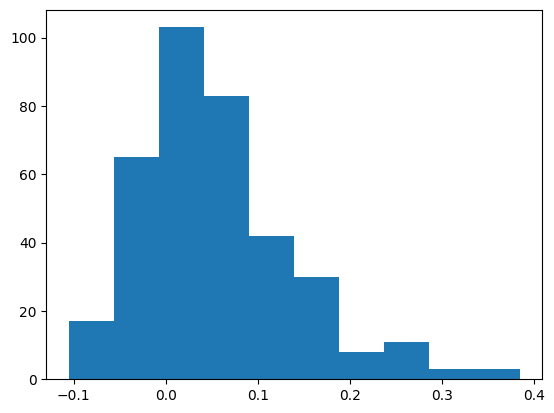

In [39]:
# Histogram for error should be normal distributed
error = mean_pred - y_test
plt.hist(error)

Ikke normaltfordelt. Vi gætter generelt på en højere togpunktlighed end true value

In [40]:
variance_error = np.var(error)
difference = variance_error - np.mean(transformed_uncertainty)
print("Difference between error variance and mean model uncertainty:", difference)

Difference between error variance and mean model uncertainty: -0.05571618616580298


De skulle gerne passe. Det er netop variansen i vores fejl vi prøver at estimere gennem uncertainty. 

Den er negativ hvilket betyder at vi overestimere usikkerheden ift. den faktiske variansen af vores faktiske fejl. Det er tilgengæld ikke meget.

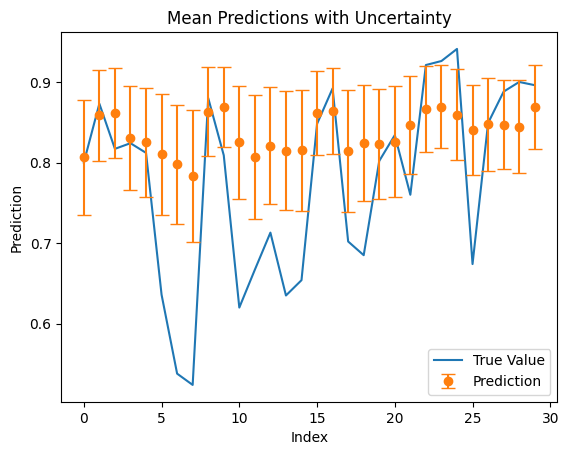

In [47]:
# Plot mean predictions with uncertainty
plt.plot(range(len(mean_pred[-30:])), y_test[-30:], label='True Value')
plt.errorbar(range(len(mean_pred[-30:])), mean_pred[-30:], yerr=transformed_uncertainty[-30:], fmt='o', capsize=5, label='Prediction')
plt.xlabel('Index')
plt.ylabel('Prediction')
plt.title('Mean Predictions with Uncertainty')
plt.legend()
plt.show()